In [1]:
# Importando bibliotecas
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Importando bibliotecas úteis para a rede
from torch.utils.data import DataLoader
# from torchsummary import summary
from torchvision import ops
import torchvision.transforms as transforms
import torchvision.utils as torch_utils
import torch.nn as nn

# Importando TravNet e seu dataset
import sys

sys.path.append('../src')

from models.TravNet_WODepth import TravNet_WODepth # EDITAR AQUI CASO QUEIRA TESTAR COM/SEM PROFUNDIDADE
from utils.TravDataloader import TravNetDataset

In [2]:
# import session_info

# session_info.show()

## Initialization

In [4]:
class Object(object):
    pass

params = Object() # Cria um objeto para armazenar os parâmetros
# Parametros do dataset
params.data_path        = r'../data/' 
params.csv_path         = os.path.join(params.data_path, 'data.csv')
params.preproc          = True  # Vertical flip augmentation - inverte a imagem verticalmente
params.depth_mean       = 3.5235
params.depth_std        = 10.6645

# Parametros de treino
params.seed             = 230 # Seed para o gerador de números aleatórios - como saber a melhor seed para o modelo?
params.epochs           = 10 # MUDAR AQUI AS ÉPOCAS
params.batch_size       = 16
params.learning_rate    = 1e-4
params.weight_decay     = 1e-5

# Parametros do modelo 
params.pretrained = True
params.load_network_path = None 
params.input_size       = (424, 240)
params.output_size      = (424, 240)
params.output_channels  = 1
params.bottleneck_dim   = 256

In [5]:
torch.manual_seed(params.seed) # Passa a seed para a CPU
if torch.cuda.is_available():
    torch.cuda.manual_seed(params.seed) # Caso disponível, passa a seed para a GPU

# Selecionar GPU ou CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda:0 device


In [6]:
def load_data():
    # Transformações para o dataset
    # Pré-estudo ablativo - Alterar aqui
    '''
    transform = transforms.Compose([
                transforms.ToPILImage(), # Converte o tensor para uma imagem PIL
                transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                transforms.RandomChoice([
                    transforms.RandomHorizontalFlip(p=1),
                    transforms.RandomRotation(15),
                    transforms.RandomInvert(0.5),
                ]),
                transforms.ToTensor(), # Converte a imagem PIL para um tensor
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # Normaliza o tensor (média e desvio padrão)
                ])
    '''
    
    transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])
    

    dataset = TravNetDataset(params, transform)

    # Divide o dataset em treino e validação 
    train_size, val_size = int(0.8*len(dataset)), np.ceil(0.2*len(dataset)).astype('int')
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size]) # Separa os dados de acordo com os tamanhos estabelecidos e embaralha

    train_loader    = DataLoader(train_dataset, batch_size=params.batch_size, shuffle=True, num_workers=2)
    val_loader     = DataLoader(val_dataset, batch_size=params.batch_size, shuffle=True, num_workers=2)

    print('Total loaded %d images' % len(dataset))
    print('Loaded %d train images' % train_size)
    print('Loaded %d valid images' % val_size)

    return train_loader, val_loader

In [ ]:
# IoU para comparar entre imagem gerada pelo estimador e pela predição da rede
def get_iou(ground_truth_bbox, prediction_bbox):
    iou = ops.box_iou(ground_truth_bbox, prediction_bbox)
    print('IOU : ', iou.numpy()[0][0])

In [7]:
# # Pré-estudo ablativo - Alterar aqui
# def fit(net, criterion, optimizer, scheduler, train_loader, val_loader):
def fit(net, criterion, optimizer, train_loader, val_loader, model):
    
    # Pré-estudo ablativo - Alterar aqui
    # patience = 10 # Número de épocas sem melhora na perda de validação para parar o treinamento
    # counter = 0 # Contador para o número de épocas sem melhora na perda de validação

    best_val_loss = np.inf # Melhor perda de validação
    train_loss_list = [] # Lista para armazenar as perdas de treino
    val_loss_list = [] # Lista para armazenar as perdas de validação

    layer_importances = {}
    for layer_name, layer in model.named_modules():
        layer_importances[layer_name] = 0.0

    for epoch in range(params.epochs):
        net.train()
        train_loss = 0.0 # Setando a perda para 0 a cada época
        
        # 'for' passando por cada imagem e cada dado do dataset
        for i, data in enumerate(train_loader):
            data = (item.to(device).type(torch.float32) for item in data) # Passa os dados para a GPU
            color_img, depth_img, path_img, mu_img, nu_img, weight = data # Separa os dados em imagens e pesos

            # Forward pass
            pred = net(color_img) # EDITAR AQUI CASO QUEIRA TESTAR COM/SEM PROFUNDIDADE
            label = mu_img

            loss = weight*criterion(pred*path_img, label) # Calcula a perda
            loss = torch.mean(loss)
            optimizer.zero_grad() # Zera os gradientes
            loss.backward() # Backpropagation
            optimizer.step() # Atualiza os pesos com o otimizador

            train_loss += loss.item() # Somando a perda de cada batch

        train_loss /= len(train_loader) # Calcula a perda média
        train_loss_list.append(train_loss) # Adiciona a perda média na lista de perdas de treino

        if (epoch) % 10 == 0:
            outstring = 'Epoch [%d/%d], Loss: ' % (epoch+1, params.epochs)
            print(outstring, train_loss)
            print('Learning Rate for this epoch: {}'.format(optimizer.param_groups[0]['lr']))

        # Testando o modelo 
        with torch.no_grad():
            net.eval() # Modo de validação

            val_loss = 0.0 # Setando a perda para 0 a cada época

            for i, data in enumerate(val_loader):
                data = (item.to(device).type(torch.float32) for item in data)
                color_img, depth_img, path_img, mu_img, nu_img, weight = data

                pred = net(color_img) # EDITAR AQUI CASO QUEIRA TESTAR COM/SEM PROFUNDIDADE
                label = mu_img

                loss = weight*criterion(pred*path_img, label)
                loss = torch.mean(loss)

                val_loss += loss.item()

                for layer_name, layer in model.named_modules():
                    if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
                        layer_importances[layer_name] += torch.sum(torch.abs(layer.weight.grad)).item()

            val_loss /= len(val_loader)
            val_loss_list.append(val_loss)

            num_test_data = len(val_loader)
            for layer_name in layer_importances:
                layer_importances[layer_name] /= num_test_data
        
            # Pré-estudo ablativo - Alterar aqui   
            '''
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                counter = 0

                # Salva o modelo
                print('Updating best validation loss: %.5f' % best_val_loss)
                torch.save(net.state_dict(), 'checkpoints/best_predictor_depth.pth')
            else:
                counter += 1
                print('No improvement since last epoch: %d' % counter)
                if counter >= patience:
                    net.module.load_state_dict(torch.load('checkpoints/best_predictor_depth.pth'))
                    print('Early stopping!')
                    break
            '''
            
        # Pré-estudo ablativo - Alterar aqui    
        # scheduler.step() # Atualiza a taxa de aprendizado
        
        if (epoch + 1) % 5 == 0:
            plt.figure(figsize = (14,14))
            plt.subplot(1, 3, 1)
            plt.imshow(color_img[0].permute(1, 2, 0).cpu().numpy())
            plt.subplot(1, 3, 2)
            plt.imshow(255*pred[0,0,:,:].detach().cpu().numpy(), vmin=0, vmax=255)
            plt.show(block=False)

            get_iou(label[0], pred[0,0,:,:].detach().cpu().numpy())

    sorted_layers = sorted(layer_importances.items(), key=lambda x: x[1], reverse=True)
    for layer_name, importance in sorted_layers:
        print(f"Layer: {layer_name}, Importance: {importance}")

    plt.plot(train_loss_list, label='Treinamento')
    plt.plot(val_loss_list, label='Validação')
    plt.xlabel('Época')
    plt.ylabel('Perda')
    plt.legend()
    plt.show()

In [8]:
train_data, val_data = load_data() # Carrega os dados

Initializing dataset
Max score: 24.567
Min score: 0.0
Depth mean: 3.438056670303481
Depth std: 10.458746256918245
Total loaded 16558 images
Loaded 13246 train images
Loaded 3312 valid images


In [14]:
# REINICIALIZAR AQUI
net = TravNet_WODepth(params) # Instancia a rede - # EDITAR AQUI CASO QUEIRA TESTAR COM/SEM PROFUNDIDADE
# summary(net, input_size=(3, 424, 240)) # Mostra o resumo da rede

# Usado para carregar um modelo salvo
if params.load_network_path is not None:
    print('Loading saved network from {}'.format(params.load_network_path))
    net.load_state_dict(torch.load(params.load_network_path))

print("Let's use", torch.cuda.device_count(), "GPUs!") # Verifica se há mais de uma GPU disponível
net = torch.nn.DataParallel(net).to(device) # Paraleliza para usar mais de uma GPU

Let's use 1 GPUs!


In [15]:
# Inicializa um tensor de teste
# EDITAR AQUI CASO QUEIRA TESTAR COM/SEM PROFUNDIDADE
test = net(torch.rand([2, 3, params.input_size[1], params.input_size[0]]).to(device)) 
print('test.shape:', test.shape)

test.shape: torch.Size([2, 1, 240, 424])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


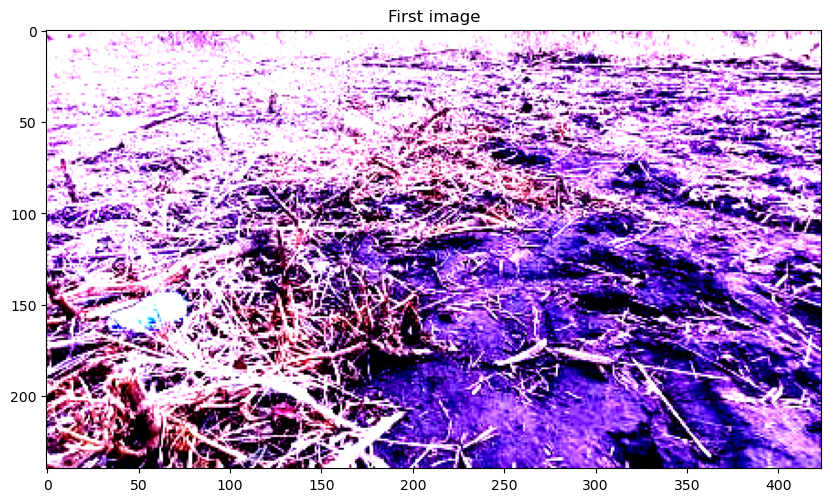

In [16]:
data_iterator = iter(train_data)
data = next(data_iterator)
first_image = data[0][0]
first_image = torch_utils.make_grid(first_image)

plt.figure(figsize=(10, 10))
plt.imshow(first_image.permute(1, 2, 0))
plt.title('First image')
plt.show()

## Set up training tools and fitting

In [17]:
criterion = torch.nn.L1Loss(reduction='none') # Perda L1 (erro absoluto médio)
optimizer = torch.optim.Adam(net.parameters(), lr=params.learning_rate, weight_decay=params.weight_decay) # Verificar o melhor otimizador para o modelo
# Pré-estudo ablativo - Alterar aqui   
# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10,20], gamma=0.1)

Epoch [1/10], Loss:  0.008509105316909921
Learning Rate for this epoch: 0.0001


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


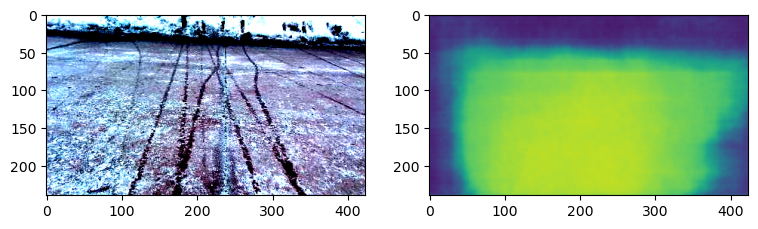

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


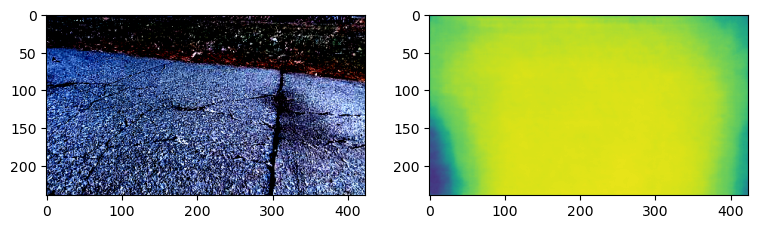

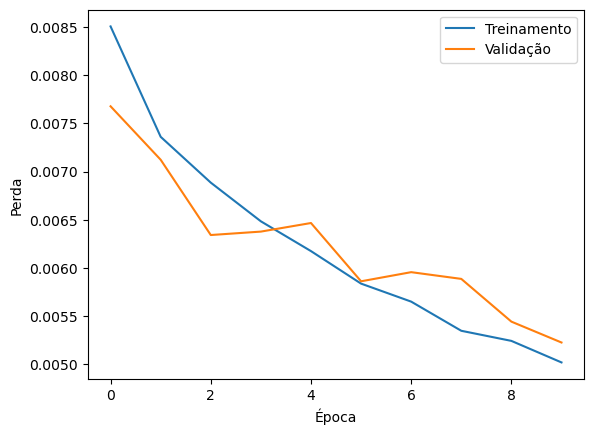

In [18]:
train = fit(net=net, criterion=criterion, optimizer=optimizer, train_loader=train_data, val_loader=val_data)
# Pré-estudo ablativo - Alterar aqui 
# train = fit(net=net, criterion=criterion, optimizer=optimizer, scheduler=scheduler, train_loader=train_data, val_loader=val_data) 